In [1]:
import os

import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

from src import settings
from src.visualization.plot import line
from src.data.utils import get_organ_labels
from src.visualization.templates import cmap_qualitative, cmap_quantitative_list
from src.data.utils import get_label_mapping, get_pa_label_mapping
from src.utils.susi import ExperimentResults

In [2]:
organs_to_plot = ['stomach', 'small_bowel', 'liver', 'spleen', 'fat']
organs_to_plot = ['colon', 'stomach', 'omentum', 'spleen', 'fat']
font_type = "NewComputerModern10"
def prepare_data(df: pd.DataFrame):
    to_replace = {
        'simulated_sampled': 'simulated',
        'small_bowel': 'small bowel',
        'inn': 'cINN',
        'unit': 'UNIT',
        'real - inn': 'real - cINN',
        'real - unit': 'real - UNIT',
        'per_class_f1': 'F1',
        'per_class_auroc': 'AUC',
        'per_class_accuracy': 'accuracy',
        'UNIT_y': 'UNIT',
        'cINN_d': 'cINN<sub>D</sub>',
        'cINN_dy': 'cINN'
    }
    to_rename = {
        'wavelength': 'wavelength [nm]',
        'reflectance': 'reflectance [a.u.]',
        'dataset': 'data',
        'source': 'data',
        'pai_signal': 'PA signal [a.u.]',
        'waic': 'WAIC [a.u.]',
        'difference': 'difference [a.u.]',
        'metric diff': 'metric relative to simulations'
    }
    new_df = df.replace(to_replace, inplace=False)
    new_df.rename(to_rename, inplace=True, axis=1)
    to_rename.update(to_replace)
    return new_df, to_rename

def compute_metric_diff(df: pd.DataFrame) -> pd.DataFrame:
    base = df[df.data == 'simulated']
    metric_diff = ExperimentResults()
    for source in df.data.unique():
        tmp = df[df.data == source]
        for metric in tmp.metric.unique():
            clf_metric = tmp[tmp.metric == metric]['metric value'].values[0]
            base_metric = base[base.metric == metric]['metric value'].values[0]
            diff = clf_metric - base_metric
            metric_diff.append(name="metric diff", value=diff)
            metric_diff.append(name="metric", value=metric)
            metric_diff.append(name="data", value=source)
    metric_df = metric_diff.get_df()
    real_baseline = metric_df[metric_df.data == 'real']
    metric_df = metric_df[
        (~metric_df.data.isin(['simulated', 'real']))
        # & (~metric_df.metric.isin(['F1-Score']))
        & (~metric_df.data.isin(['cINN_d', 'UNIT']))
    ]
    metric_df, mapper = prepare_data(metric_df)
    return metric_df, mapper, real_baseline

# plot HSI classification metrics

In [3]:
# metrics_file = settings.results_dir / 'rf' / 'rf_classifier_metrics.csv'
# df = pd.read_csv(metrics_file, index_col=None, header=[0])
# df = df.melt(id_vars=["data"], value_name="metric value", var_name="metric")
# metric_df, mapper, real_base = compute_metric_diff(df=df)
# fig = px.bar(
#     data_frame=metric_df,
#     x="data",
#     y=mapper.get('metric diff'),
#     color="data",
#     facet_col="metric",
#     color_discrete_map=cmap_qualitative,
#     template="plotly_white",
# )
# fig.add_shape(
#     type="line",
#     x0=-0.4,
#     x1=0.4,
#     y0=0,
#     y1=0,
#     line=dict(
#         color=cmap_qualitative['UNIT'],
#         width=6,
#     )
# )
# fig.add_hline(
#     y=0,
#     line_color=cmap_qualitative.get('simulated'),
#     annotation_font={'color': cmap_qualitative.get('simulated')},
#     line_dash="dash",
#     line_width=4,
#     annotation_text="",
#     annotation_position="bottom right",
#     annotation_font_size=14,
#     annotation_font_color=cmap_qualitative.get('simulated'),
#     row="all",
#     col="all"
#     )
# font_size = 28
# fig.update_xaxes(title_font=dict(size=font_size, family=font_type),
#                  tickangle=270,
#                  showticklabels=False,
#                  title=""
#                  )
# fig.update_yaxes(title_font=dict(size=font_size, family=font_type))
# # fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
# fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
# fig.update_layout(font=dict(size=font_size, family=font_type, color="#000000"),
#                   legend=dict(orientation="h", xanchor="center", x=0.5, y=0., title=""),
#                   margin=dict(l=0, r=0, t=30, b=0))
# fig.write_image(settings.figures_dir / 'manuscript' / 'semantic_metrics.pdf')
# fig.write_image(settings.figures_dir / 'manuscript' / 'semantic_metrics.png', scale=2)
# fig.write_image(settings.figures_dir / 'manuscript' / 'semantic_metrics.svg')
#

In [4]:
# metrics_file = settings.results_dir / 'rf' / 'rf_classifier_metrics.csv'
# metrics_df = pd.read_csv(metrics_file, index_col=None, header=[0])
# metrics_df, _ = prepare_data(metrics_df)
# organs = metrics_df.organ.unique()
# metric = ('AUC', 'per_class_auroc')
# results = ExperimentResults()
# metric_diff_value = []
# for organ in organs:
#     tmp = metrics_df[(metrics_df.organ == organ)]
#     base_value = tmp[tmp.data == 'simulated'][metric[1]].values[0]
#     values = []
#     for j, source in enumerate(['cINN', 'UNIT']):
#         metric_value = tmp[tmp['data'] == source][metric[1]].values[0]
#         diff = metric_value - base_value
#         values.append(float(diff))
#         results.append(name="organ", value=organ)
#         results.append(name="data", value=source)
#         results.append(name=metric[0], value=diff)
#     metric_diff_value.append(values)
# df = results.get_df()
# df = df[~df['data'].isin(['simulated', 'real'])]
# df, _ = prepare_data(df)
# fig = px.bar(
#     data_frame=df,
#     x="data",
#     y=metric[0],
#     color="data",
#     template="plotly_white",
#     facet_col="organ",
#     facet_col_wrap=5,
#     color_discrete_map=cmap_qualitative,
#     facet_col_spacing=0.1,
#     category_orders={'organ': list(organs)}
# )
# fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
# fig.update_layout(template="plotly_white",
#                   # width=1000,
#                   # height=400,
#                   margin=dict(l=20, r=20, t=20, b=20)
#                   )
# for i, values in enumerate(metric_diff_value):
#     if i>0:
#         col = (i%5) + 1
#     else:
#         col = 1
#     if i < 5:
#         row = 2
#     else:
#         row = 1
#
#     y_range = [-max(np.abs(values)), max(np.abs(values))]
#     fig.update_yaxes(range=y_range, row=row, col=col)
# fig.update_traces(width=0.5)
# fig.update_layout(font=dict(size=12, family=font_type))
# fig.update_xaxes(title_font=dict(size=12, family=font_type), tickangle=270)
# fig.update_yaxes(title_font=dict(size=12, family=font_type), matches=None)
# fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
# fig.write_image(settings.figures_dir / 'manuscript' / f'semantic_{metric[0]}.png', scale=3)
# fig.write_image(settings.figures_dir / 'manuscript' / f'semantic_{metric[0]}.pdf')
# fig.write_image(settings.figures_dir / 'manuscript' / f'semantic_{metric[0]}.svg')
# fig.write_html(settings.figures_dir / 'manuscript' / f'semantic_{metric[0]}.html')

# plot HSI spectra

In [4]:
spectra_file = settings.figures_dir / 'semantic_reflectance.csv'
df = pd.read_csv(spectra_file)
df = df[df.organ != 'gallbladder']
organs = [' '.join(o.split('_')) for o in organs_to_plot]
df = df[df['organ'].isin(organs_to_plot)]
df_prepared, mapper = prepare_data(df)
fig, plot_data = line(
    data_frame=df_prepared,
    x=mapper.get("wavelength"),
    y=mapper.get('reflectance'),
    facet_col="organ",
    color=mapper.get("dataset"),
    facet_col_wrap=5,
    template="plotly_white",
    width=800,
    height=300,
    category_orders=dict(organ=organs, data=['real', 'simulated', 'UNIT', 'cINN']),
    facet_row_spacing=0.2,
    facet_col_spacing=0.05,
    color_discrete_map=cmap_qualitative,
    # range_x=(900, 1000),
    # range_y=(0.005, 0.015)
    range_y=(0.0, 0.025)
)
# fig.add_vrect(x0=900,
#               x1=1000,
#               row="all",
#               col="all",
#               fillcolor="gray",
#               opacity=0.25,
#               line_width=0
#               )
font_size = 22
fig.update_xaxes(title_font=dict(size=font_size, family=font_type), tickangle=270,
                 # showgrid=False,
                 )
fig.update_yaxes(title_font=dict(size=font_size, family=font_type),
                 # showgrid=False,
                 )
fig.update_annotations(font=dict(size=font_size, family=font_type))
# fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_layout(font=dict(size=font_size, family=font_type, color='#000000'),
                  margin=dict(l=0, r=0, t=0, b=10),
                  legend=dict(orientation="h", xanchor="center", x=0.5, y=1.3, title="")
                  )
os.makedirs(settings.figures_dir / 'manuscript')
print(settings.figures_dir / 'manuscript' / 'semantic_reflectance')
fig.write_image(settings.figures_dir / 'manuscript' / 'semantic_reflectance.pdf')
fig.write_image(settings.figures_dir / 'manuscript' / 'semantic_reflectance.svg')
fig.write_image(settings.figures_dir / 'manuscript' / 'semantic_reflectance.png', scale=2)
fig.write_html(settings.figures_dir / 'manuscript' / 'semantic_reflectance.html')

FileNotFoundError: [Errno 2] No such file or directory: '/home/kris/Work/Repositories/miccai23/src/visualization/figures/semantic_reflectance.csv'

# plot HSI spectral differences

In [6]:
df = pd.read_csv(settings.figures_dir / 'semantic_diff.csv')
organs = get_organ_labels()['organ_labels']
organs = [o for o in organs if o != 'gallbladder' and o in organs_to_plot]
df = df[df['organ'].isin(organs)]
organs = [' '.join(o.split('_')) for o in organs]
df_prepared, mapper = prepare_data(df)
fig = px.violin(data_frame=df_prepared,
             x="data",
             y=mapper.get('difference'),
             color="data",
             facet_col="organ",
             facet_col_wrap=5,
             color_discrete_map=cmap_qualitative,
             template="plotly_white",
             category_orders=dict(organ=organs_to_plot, data=['real - simulated', 'real - UNIT', 'real - cINN']),
             facet_row_spacing=0.2,
             facet_col_spacing=0.05,
             width=800,
             height=400,
                points="all"
             )
fig.update_traces(scalemode='width', meanline_visible=True, line=dict(width=3))
TRACE_INDEX = []
def split_scale_group(tr):
    if TRACE_INDEX:
        TRACE_INDEX.append(TRACE_INDEX[-1] + 1)
    else:
        TRACE_INDEX.append(0)
    tr.scalegroup = TRACE_INDEX[-1]
    return tr
fig.for_each_trace(split_scale_group)
font_size=18
fig.update_layout(font=dict(size=font_size, family=font_type, color="#000000"),
                  legend=dict(orientation="h", xanchor="center", x=0.5, y=0., title=""),
                  margin=dict(l=0, r=0, t=30, b=0)
                  )
fig.update_xaxes(title_font=dict(size=font_size, family=font_type),
                 showticklabels=False, title="")
fig.update_yaxes(title_font=dict(size=font_size, family=font_type),
                 range=(0, 0.005))
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
os.makedirs(settings.figures_dir / 'manuscript')
fig.write_image(settings.figures_dir / 'manuscript' / 'semantic_diff.pdf')
fig.write_image(settings.figures_dir / 'manuscript' / 'semantic_diff.svg')
fig.write_image(settings.figures_dir / 'manuscript' / 'semantic_diff.png', scale=2)

FileExistsError: [Errno 17] File exists: '/home/kris/Work/Data/Test/figures/manuscript'

# plot HSI confusion matrices

In [7]:
stages = [
    'real',
    'simulated',
    'cINN',
    'UNIT'
]
stage_mapper = dict(real='real', sampled='simulated', adapted_inn='cINN', unit='UNIT')
mapping = get_label_mapping()
for stage in stages:
    file = settings.results_dir / 'rf' / f"rf_classifier_matrix_{stage}.npz"
    data = np.load(file)
    matrix = data['matrix']
    labels = data['labels']
    names = [mapping.get(str(l)) for l in labels]
    names = [' '.join(n.split('_')) for n in names]
    fig = px.imshow(matrix,
                    text_auto='.2f',
                    color_continuous_scale=cmap_quantitative_list.get(stage),
                    zmin=0,
                    zmax=1,
                    template='plotly_white',
                    labels={'small_bowel': 'small bowel'}
                    )
    axis_ticks = dict(
            tickmode='array',
            tickvals=np.arange(0, len(names)),
            ticktext=names
        )
    fig.update_layout(
        xaxis=axis_ticks,
        yaxis=axis_ticks,
        coloraxis_colorbar=dict(
            title="probability",
            x=0.85,
            ticks="outside",
            ticksuffix="",
        )
    )
    font_size = 18
    fig.update_xaxes(title="predicted class", title_font=dict(size=font_size, family=font_type))
    fig.update_yaxes(title="true class", title_font=dict(size=font_size, family=font_type))
    fig.update_layout(font=dict(size=font_size, family=font_type, color='#000000'),
                      margin=dict(l=10, r=0, t=10, b=10))
    os.makedirs(settings.figures_dir / 'manuscript')
    fig.write_image(settings.figures_dir / 'manuscript' / f'semantic_rf_confusion_matrix_{stage}.pdf')
    fig.write_image(settings.figures_dir / 'manuscript' / f'semantic_rf_confusion_matrix_{stage}.svg')
    fig.write_image(settings.figures_dir / 'manuscript' / f'semantic_rf_confusion_matrix_{stage}.png', scale=2)

FileExistsError: [Errno 17] File exists: '/home/kris/Work/Data/Test/figures/manuscript'

# plot HSI PCA

FileExistsError: [Errno 17] File exists: '/home/kris/Work/Data/Test/figures/manuscript/semantic_pca'

<Figure size 600x600 with 0 Axes>

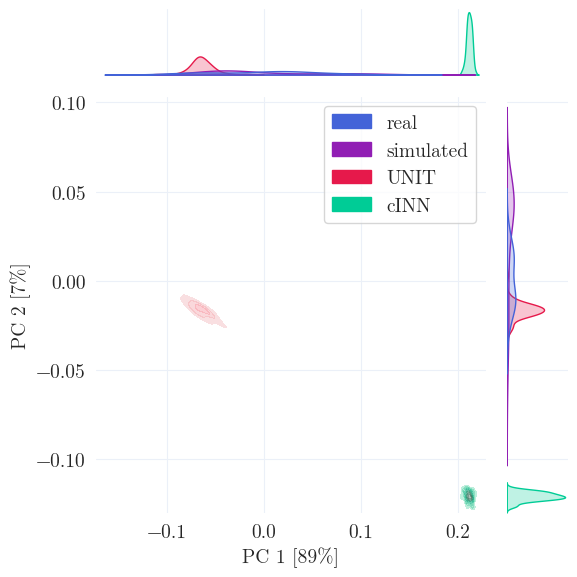

In [8]:
df = pd.read_csv(settings.figures_dir  / 'semantic_pca.csv')
df, mapper = prepare_data(df)
sns.set_style('whitegrid', {"grid.color": "ebf0f8ff", "grid.linewidth": 1})
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = [font_type]
plt.rcParams["font.size"] = 14

for organ in df.organ.unique():
    model_file = settings.results_dir / 'pca' / f"semantic_pca_{'_'.join(organ.split(' '))}.joblib"
    model = joblib.load(model_file)
    tmp = df[df['organ'] == organ].copy()
    tmp = tmp.rename({'pc_1': f"PC 1 [{round(model.explained_variance_ratio_[0]*100)}%]",
                       'pc_2': f"PC 2 [{round(model.explained_variance_ratio_[1]*100)}%]"},
                     axis=1)
    g = sns.jointplot(data=tmp,
                      x=f"PC 1 [{round(model.explained_variance_ratio_[0]*100)}%]",
                      y=f"PC 2 [{round(model.explained_variance_ratio_[1]*100)}%]",
                      hue="data",
                      kind="kde",
                      fill=True,
                      alpha=0.4,
                      marginal_kws={'common_norm': False},
                      palette=cmap_qualitative,
                      levels=10)
    leg = g.figure.axes[0].get_legend()
    leg.set_title("")
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    os.makedirs(settings.figures_dir / 'manuscript' / 'semantic_pca')
    plt.savefig(settings.figures_dir / 'manuscript' / 'semantic_pca' / f'semantic_pca_{organ}.pdf')
    plt.savefig(settings.figures_dir / 'manuscript' / 'semantic_pca' / f'semantic_pca_{organ}.png', dpi=300)
    plt.clf()

# plot PAI signal

In [9]:
df = pd.read_csv(settings.figures_dir / 'pai_signal.csv')
df, mapper = prepare_data(df)
for tissue in df.tissue.unique():
    tmp = df[df.tissue == tissue]
    fig, _ = line(data_frame=tmp,
                  x=mapper.get("wavelength"),
                  y=mapper.get('pai_signal'),
                  facet_col=None,
                  color="data",
                  template="plotly_white",
                  color_discrete_map=cmap_qualitative,
                  width=500,
                  category_orders=dict(data=['real', 'simulated', 'UNIT', 'cINN'])
               )
    font_size = 20
    fig.update_layout(font=dict(size=font_size, family=font_type, color="#000000"),
                      legend=dict(orientation="h", xanchor="center", x=0.5, y=1, title=""),
                      margin=dict(l=20, r=10, t=10, b=20)
                      )
    fig.update_xaxes(title_font=dict(size=font_size, family=font_type))
    fig.update_yaxes(title_font=dict(size=font_size, family=font_type))
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
    os.makedirs(settings.figures_dir / 'manuscript')
    fig.write_image(settings.figures_dir / 'manuscript' / f'pai_signal_{tissue}.pdf')
    fig.write_image(settings.figures_dir / 'manuscript' / f'pai_signal_{tissue}.svg')
    fig.write_image(settings.figures_dir / 'manuscript' / f'pai_signal_{tissue}.png', scale=2)

FileExistsError: [Errno 17] File exists: '/home/kris/Work/Data/Test/figures/manuscript'

# plot PAI metrics

In [10]:
# metrics_file = settings.results_dir / 'rf_pa' / 'rf_classifier_metrics.csv'
# df = pd.read_csv(metrics_file, index_col=None, header=[0])
# df = df.melt(id_vars=["data"], value_name="metric value", var_name="metric")
# metric_df, mapper, real_base = compute_metric_diff(df=df)
# fig = px.bar(
#     data_frame=metric_df,
#     x="data",
#     y=mapper.get('metric diff'),
#     color="data",
#     facet_col="metric",
#     color_discrete_map=cmap_qualitative,
#     template="plotly_white",
# )
# fig.add_hline(
#     y=0,
#     line_color=cmap_qualitative.get('simulated'),
#     annotation_font={'color': cmap_qualitative.get('simulated')},
#     line_dash="dash",
#     line_width=4,
#     annotation_text="",
#     annotation_position="bottom right",
#     annotation_font_size=14,
#     annotation_font_color=cmap_qualitative.get('simulated'),
#     row="all",
#     col="all"
#     )
# font_size = 28
# fig.update_xaxes(title_font=dict(size=font_size, family=font_type),
#                  tickangle=270,
#                  showticklabels=False,
#                  title=""
#                  )
#
# fig.update_layout(font=dict(size=font_size, family=font_type, color="#000000"),
#                   legend=dict(orientation="h", xanchor="center", x=0.5, y=0., title=""),
#                   margin=dict(l=0, r=0, t=30, b=0)
#                   )
# fig.update_xaxes(title_font=dict(size=font_size, family=font_type), tickangle=270, title="")
# fig.update_yaxes(title_font=dict(size=font_size, family=font_type),
#                  range=(-0.04, 0.24)
#                  )
# # fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
# fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
# fig.write_image(settings.figures_dir / 'manuscript' / 'pai_metrics.pdf')
# fig.write_image(settings.figures_dir / 'manuscript' / 'pai_metrics.svg')
# fig.write_image(settings.figures_dir / 'manuscript' / 'pai_metrics.png', scale=2)

# plot PAI signal differences

In [11]:
df = pd.read_csv(settings.figures_dir / 'pai_diff.csv')
if 'difference [%]' in df.columns:
    df['difference [%]'] *= 100
df, mapper = prepare_data(df)
tissues = df.tissue.unique()
for tissue in tissues:
    tmp = df[df.tissue==tissue]
    fig = px.violin(data_frame=tmp,
                 x="data",
                 y=mapper.get('difference'),
                 color="data",
                 color_discrete_map=cmap_qualitative,
                 template="plotly_white",
                 category_orders=dict(tissue=['vein', 'artery'], data=['real - simulated', 'real - UNIT', 'real - cINN']),
                 facet_col_spacing=0.05,
                    width=600,
                    height=500,
                    points="all"
                 )
    fig.update_traces(scalemode='width', meanline_visible=True)
    TRACE_INDEX = []
    def split_scale_group(tr):
        if TRACE_INDEX:
            TRACE_INDEX.append(TRACE_INDEX[-1] + 1)
        else:
            TRACE_INDEX.append(0)
        tr.scalegroup = TRACE_INDEX[-1]
        return tr
    fig.for_each_trace(split_scale_group)
    fig.update_traces(line=dict(width=4))
    font_size = 24
    fig.update_layout(font=dict(size=font_size, family=font_type, color="#000000"),
                      legend=dict(orientation="h", xanchor="center", x=0.5, y=0., title="", font_size=font_size),
                      margin=dict(l=0, r=0, t=0, b=0),
                      )
    fig.update_xaxes(title_font=dict(size=font_size, family=font_type),
                     tickangle=0,
                     showticklabels=False,
                     title=""
                     )
    fig.update_yaxes(title_font=dict(size=font_size, family=font_type))
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
    os.makedirs(settings.figures_dir / 'manuscript')
    fig.write_image(settings.figures_dir / 'manuscript' / f'pai_diff_{tissue}.pdf')
    fig.write_image(settings.figures_dir / 'manuscript' / f'pai_diff_{tissue}.svg')
    fig.write_image(settings.figures_dir / 'manuscript' / f'pai_diff_{tissue}.png', scale=2)

FileExistsError: [Errno 17] File exists: '/home/kris/Work/Data/Test/figures/manuscript'

# plot PAI PCA

FileExistsError: [Errno 17] File exists: '/home/kris/Work/Data/Test/figures/manuscript'

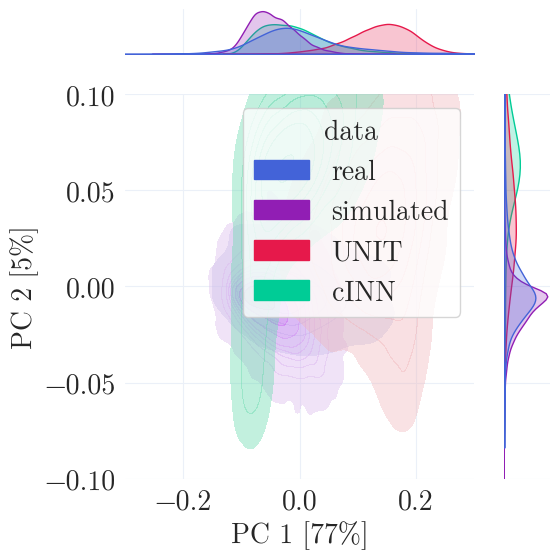

In [12]:
df = pd.read_csv(settings.results_dir / 'pca' / 'pai_pca.csv')
# df = df[df['data'] != 'unit']
df, mapper = prepare_data(df)
sns.set_style('whitegrid', {"grid.color": "ebf0f8ff", "grid.linewidth": 1})
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = [font_type]
plt.rcParams["font.size"] = 20

for tissue in df.tissue.unique():
    model_file = settings.results_dir / 'pca' / f'pai_pca_{tissue}.joblib'
    model = joblib.load(model_file)
    tmp = df[df['tissue'] == tissue].copy()
    tmp = tmp.rename({'pc_1': f"PC 1 [{round(model.explained_variance_ratio_[0]*100)}%]",
                       'pc_2': f"PC 2 [{round(model.explained_variance_ratio_[1]*100)}%]"},
                     axis=1)
    g = sns.jointplot(data=tmp,
                      x=f"PC 1 [{round(model.explained_variance_ratio_[0]*100)}%]",
                      y=f"PC 2 [{round(model.explained_variance_ratio_[1]*100)}%]",
                      hue="data",
                      kind="kde",
                      fill=True,
                      alpha=0.4,
                      marginal_kws={'common_norm': False},
                      palette=cmap_qualitative,
                      levels=10)
    leg.set_title("")
    plt.xlim(-0.3, 0.3)
    plt.ylim(-0.1, 0.1)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    os.makedirs(settings.figures_dir / 'manuscript')
    plt.savefig(settings.figures_dir / 'manuscript' / f'pai_pca_{tissue}.pdf')
    plt.savefig(settings.figures_dir / 'manuscript' / f'pai_pca_{tissue}.svg')
    plt.savefig(settings.figures_dir / 'manuscript' / f'pai_pca_{tissue}.png', dpi=300)

# plot PAI confusion matrices

In [13]:
stages = [
    'real',
    'simulated',
    'cINN',
    'UNIT'
]
mapping = get_pa_label_mapping()
for stage in stages:
    file = settings.results_dir / 'rf_pa' / f"rf_pa_classifier_matrix_{stage}.npz"
    data = np.load(file)
    matrix = data['matrix']
    labels = data['labels']
    names = [mapping.get(l) for l in labels]
    names = [' '.join(n.split('_')) for n in names]
    fig = px.imshow(matrix,
                    text_auto='.2f',
                    color_continuous_scale=cmap_quantitative_list.get(stage),
                    zmin=0,
                    zmax=1,
                    template='plotly_white',
                    labels={'small_bowel': 'small bowel'}
                    )
    axis_ticks = dict(
            tickmode='array',
            tickvals=np.arange(0, len(names)),
            ticktext=names
        )
    fig.update_layout(
        xaxis=axis_ticks,
        yaxis=axis_ticks,
        coloraxis_colorbar=dict(
            title=dict(text="", side="right"),
            x=0.85,
            ticks="outside",
            ticksuffix="",
        )
    )
    fig.update_xaxes(title="predicted class", title_font=dict(size=40, family=font_type))
    fig.update_yaxes(title="true class", title_font=dict(size=40, family=font_type))
    fig.update_layout(font=dict(size=40, family=font_type, color="#000000"))
    os.makedirs(settings.figures_dir / 'manuscript')
    fig.write_image(settings.figures_dir / 'manuscript' / f'pai_rf_confusion_matrix_pa_{stage}.pdf')
    fig.write_image(settings.figures_dir / 'manuscript' / f'pai_rf_confusion_matrix_pa_{stage}.svg')
    fig.write_image(settings.figures_dir / 'manuscript' / f'pai_rf_confusion_matrix_pa_{stage}.png', scale=2)

FileExistsError: [Errno 17] File exists: '/home/kris/Work/Data/Test/figures/manuscript'